# Code for Estimating Neural Network's Performance with Bootstrap: a Tutorial

**Authors:**

Umberto Michelucci, umberto.michelucci@toelt.ai, 

Francesca Venturini, vent@zhaw.ch

This code is the companion of the paper _Estimating Neural Network's Performance with Bootstrap: a Tutorial_ submitted for publication.

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib
font = {'size'   : 16}

matplotlib.rc('font', **font) 

import time
import pickle

## Useful functions

In [5]:
def dump_list(list, name):
  with open(name+'.pkl', 'wb') as fp:
    pickle.dump(list, fp)

In [6]:
def gaussian(x, mu, sigma):
  tmp = 1.0/sigma/np.sqrt(2/np.pi)*np.exp(-(x-mu)**2/2.0/sigma**2)

  return tmp

# Data Generation

The data has been generated as described in the paper in **Algorithm 7.1**.

In [7]:
def f(x):
  return 2+3*x+4*x**2

In [9]:
x = np.arange(-5,5,0.02)
y = f(x) / 50

Now random uniform noise will be added.

In [10]:
eps = np.random.rand(len(x))

In [11]:
y_ = y + (eps-0.5)

We can plot the data to have an idea about how the input points look like.

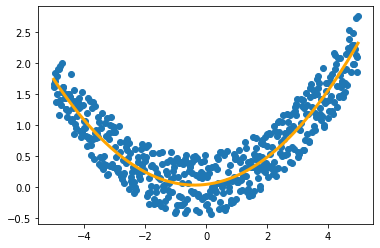

In [12]:
plt.scatter(x,y_)
plt.plot(x,y,color = 'orange', lw = 3)
plt.show()

Now we split the dataset in two parts: $S_T$ and $S_V$.

In [13]:
x_train,x_test,y_train,y_test=train_test_split(x,y_,test_size=0.2,random_state=123)

# A simple network to solve the problem

We can create a simple network as the one described in the paper, to see how it can solve the problem of extracting the underlying polynomial from the noise

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4, activation='sigmoid'),
  tf.keras.layers.Dense(4, activation='sigmoid'),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

In [15]:
model.fit(x_train,y_train, epochs=300, batch_size = 24, verbose = 0)

In [16]:
tildey = model.predict(x)

The plot below show how good the network is in solving the problem. The small difference at the edges is a known phenomena. The network performs less well, since it has less data after the edges to correct its result.

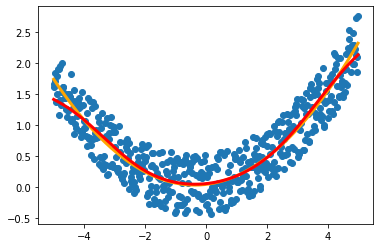

In [17]:
plt.scatter(x,y_)
plt.plot(x,y,color = 'orange', lw = 3)
plt.plot(x,tildey,color = 'red', lw = 3)
plt.show()

We can then evaluate the MSE we have using the NNM applied to the test dataset ```x_test```.

In [18]:
model.evaluate(x_test,y_test)[1]

4/4 [==============================] - 0s 949us/step - loss: 0.0815 - mse: 0.0815


0.08146438747644424

# Split/Train Algorithm (Algorithm 6.1)
 
The following code is a very basic implementation of the Split/Train algorithm (**Algorithm 6.1** in the paper).

In [25]:
val_mse = []
#
# This code runs for only 50 splits. If you want to try for more iterations change this number.
# CAREFUL: it will take some time!
#
for i in range(0,50):

  if (i % 5 == 0):
    print("Iteration",i)

  x_train,x_test,y_train,y_test=train_test_split(x,y_,test_size=0.2,random_state=i)

  model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4, activation='sigmoid'),
  tf.keras.layers.Dense(4, activation='sigmoid'),
  tf.keras.layers.Dense(1)
  ])

  model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])
  
  model.fit(x_train,y_train, epochs=300, batch_size = 16, verbose = 0)

  val_mse.append(model.evaluate(x_test,y_test, verbose = 0)[1])

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 25
Iteration 30
Iteration 35
Iteration 40
Iteration 45


As discussed in the paper some models will not learn well. Check for example in the output above the second model. It reaches a value of 0.22 for the MSE, that is much higher than 0.08 that we observed in our small test at the beginning. As mentioned in the paper we must be careful and exclude models that have clearly not converged well.

We do that in the following line, by eliminating models that have learned not well.

In [26]:
val_mse_red = np.array(val_mse)[np.array(val_mse) < 0.15]   

In [27]:
print(np.mean(val_mse_red))
print(np.std(val_mse_red))

0.08961265296378035
0.01124553732237231


Note that this plot does not look like a Gaussian (like the plots in the paper) since the number of splits is way too low. To obtain a Gaussian shape you should go over 2000 splits, but that will require quite some time.

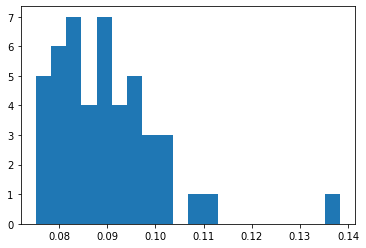

In [29]:
plt.hist(val_mse_red, bins = 20)
plt.show()

# Bootstrap Algorithm (Algorithm 6.2)

For Algorithm 6.2 we first train a network once on $S_T$. Then we will apply bootstrap to $S_V$.

In [30]:
start = time.time()

x_train,x_test,y_train,y_test=train_test_split(x,y_,test_size=0.2,random_state=30)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(4, activation='sigmoid'),
  tf.keras.layers.Dense(4, activation='sigmoid'),
  tf.keras.layers.Dense(1)
  ])

model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])
  
model.fit(x_train,y_train, epochs=300, batch_size = 16, verbose = 0)

model.evaluate(x_test,y_test)[1]

end = time.time()
print((end - start)/60.0, "min elapsed.")

4/4 [==============================] - 0s 1ms/step - loss: 0.0796 - mse: 0.0796
0.050821069876352945 min elapsed.


In [31]:
start = time.time()
N = 2000
bootstrap_mse = []
for i in range(N): # 100 Bootstrap samples
    if (i % 200 == 0):
        print("Iteration", i)
    idx = np.random.choice(np.arange(len(x_test)), len(x_test), replace=True)
    x_sample = x_test[idx]
    y_sample = y_test[idx]
    bootstrap_mse.append(model.evaluate(x_sample, y_sample, verbose = 0)[1])



end = time.time()
print((end - start)/60.0, "min elapsed.")

Iteration 0
Iteration 200
Iteration 400
Iteration 600
Iteration 800
Iteration 1000
Iteration 1200
Iteration 1400
Iteration 1600
Iteration 1800
0.9627699176470439 min elapsed.


In [32]:
print(np.mean(bootstrap_mse))
print(np.std(bootstrap_mse))

0.07993609647080302
0.007824262349777742


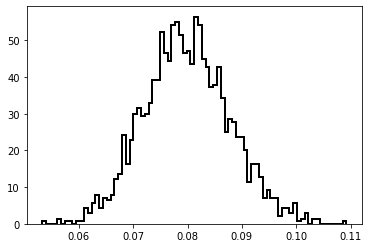

In [33]:
fig = plt.figure(figsize = (10,6))
hist = plt.hist((np.array(bootstrap_mse)), bins = 80, histtype = 'step', lw = 2, label = r"Validation MSE", color = 'black', density = True)

# Conclusions

You can see how the bootstrap is much faster and allow to perform a much higher number of simulations than the Split/Train Algorithm.

# References

In case you use this code and you want to reference it you can use the following

**Plain Text**: 
    
    Michelucci, U. Code for Estimating Neural Network’s Performance with Bootstrap: 
    a Tutorial, https://github.com/toelt-llc/NN-Performance-Bootstrap-Tutorial, 2021

**bibtex**:

    @misc{code,
      author = {Michelucci, U.},
      title = {Code for {\sl Estimating Neural Network's Performance with Bootstrap: a Tutorial}},
      year = {2021},
      publisher = {GitHub},
      journal = {GitHub repository},
      howpublished = {\url{https://github.com/toelt-llc/NN-Performance-Bootstrap-Tutorial}
    }}